In [ ]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [5]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample, evaluation
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import os
import csv
import warnings
import logging
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt

logging.disable(logging.WARNING)
warnings.filterwarnings("ignore")

In [8]:
model_name = "nli-distilroberta-base-v2"
train_batch_size = 16

model = SentenceTransformer(model_name)

def my_loss(output, label):
    loss = losses.CosineSimilarityLoss(model=model)(output, label)
    return loss


df = pd.read_csv("train.csv", delimiter='\t', encoding="utf-8").dropna()

df['score'] = df['score'].astype(float) / 5.0
trainsentences1 = []
trainsentences2 = []
trainscores = []
train_samples = []
for index, row in df.iterrows():
    inp_example = InputExample(texts=[row["sentence1"], row["sentence2"]], label=row["score"])
    train_samples.append(inp_example)
    score = float(row["score"]) / 5.0
    trainsentences1.append(row["sentence1"])
    trainsentences2.append(row["sentence2"])
    trainscores.append(score)

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)


epochs = 2
df = pd.read_csv("dev.csv", delimiter="\t", encoding="utf-8").dropna()

devsentences1 = []
devsentences2 = []
devscores = []

for index, row in df.iterrows():
    score = float(row["score"]) / 5.0
    devsentences1.append(row["setence1"])
    devsentences2.append(row["sentence2"])
    devscores.append(score)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs = epoch+1)
    trainembeddings1 = model.encode(trainsentences1, convert_to_tensor=True)
    trainembeddings2 = model.encode(trainsentences2, convert_to_tensor=True)
    train_cosine_scores = util.cos_sim(trainembeddings1, trainembeddings2)
    train_predictions = []
    for i in range(len(train_cosine_scores)):
        train_predictions.append(train_cosine_scores[i][i])
    mse_loss = mean_squared_error(train_predictions, trainscores)
    train_losses.append(mse_loss)
    devembeddings1 = model.encode(devsentences1, convert_to_tensor=True)
    devembeddings2 = model.encode(devsentences2, convert_to_tensor=True)
    dev_cosine_scores = util.cos_sim(devembeddings1, devembeddings2)
    dev_predictions = []
    for i in range(len(dev_cosine_scores)):
        dev_predictions.append(dev_cosine_scores[i][i])
    mse_loss = mean_squared_error(dev_predictions, devscores)   #cosine similarity loss has been implemented here (where loss_fct = MSE LOSS)
    val_losses.append(mse_loss*10)
    pearson_corr, _ = pearsonr(dev_predictions, devscores)
    print(f"Epoch : {epoch} Train loss : {train_losses[-1]} Val loss : {val_losses[-1]} Pearson Correlation : {pearson_corr}")


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch : 0 Train loss : 0.3152616332640056 Val loss : 0.26872962171040315 Pearson Correlation : 0.8705970383070621


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Epoch : 1 Train loss : 0.3000498040994424 Val loss : 0.23635153107614582 Pearson Correlation : 0.8806409824206274


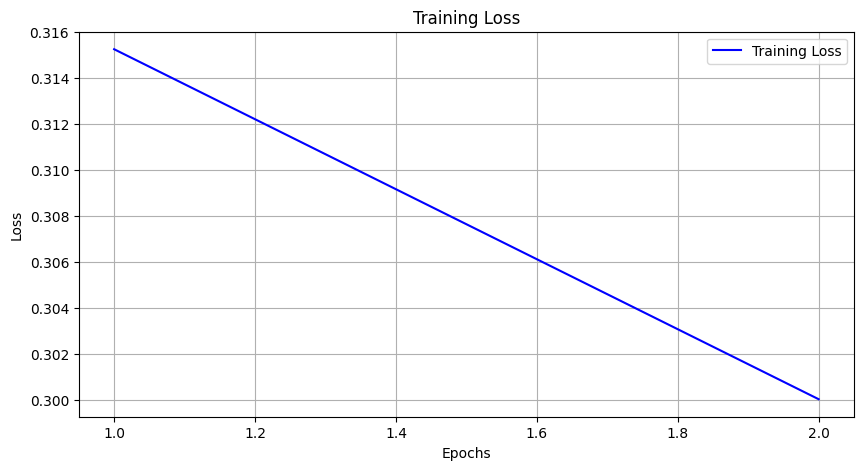

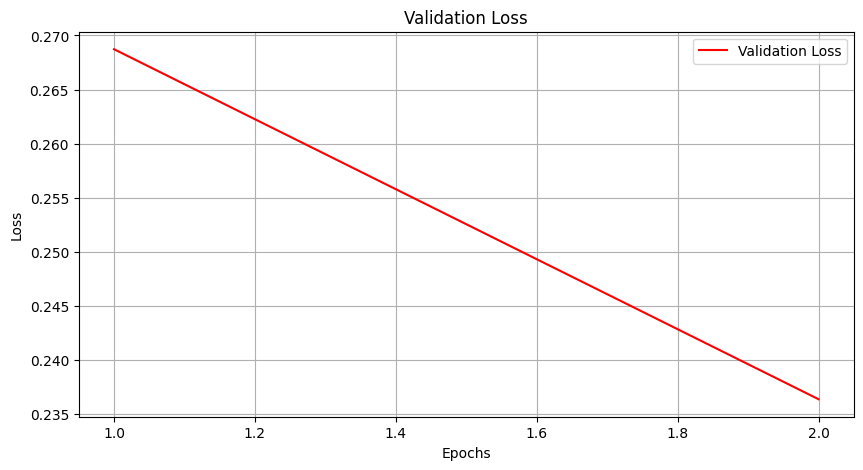

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

with open('model_setup1C_new.pkl', 'wb') as f:
    pickle.dump(model, f)